## Homework 3: Markov Process
STAT 201A

Leon (Wuji) Han

GitHub: LeonWujiHan

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Simulation of Markov Process

In [2]:
P = np.array(
    [
        [0.2, 0.7, 0.1],
        [0.2, 0.5, 0.3],
        [0.2, 0.4, 0.4]
    ]
)
print(P)

[[0.2 0.7 0.1]
 [0.2 0.5 0.3]
 [0.2 0.4 0.4]]


In [3]:
class MarkovChain:
    def __init__(self, p, init):
        assert len(p.shape) == 2 and p.shape[0] == p.shape[1]
        self.p = p
        self.state_num = self.p.shape[0]
        self.state = init # 0, 1, 2, ...
        self.gen = 0
        self.history = [init]
    def _update(self):
        new_state = np.random.choice(self.state_num, p=self.p[self.state,:])
        self.gen += 1
        self.history.append(new_state)
        self.state = new_state
    def update(self, n):
        for _ in range(n):
            self._update()

chain = MarkovChain(P, 0)

In [4]:
chain.update(999)
print(np.unique(chain.history, return_counts=True))

(array([0, 1, 2]), array([198, 502, 300]))


### Stationary Distribution

In [5]:
np.linalg.eig(P.T)

(array([1.00000000e+00, 1.36392633e-16, 1.00000000e-01]),
 array([[ 3.22458464e-01,  2.67261242e-01,  1.07331375e-16],
        [ 8.24060518e-01, -8.01783726e-01, -7.07106781e-01],
        [ 4.65773337e-01,  5.34522484e-01,  7.07106781e-01]]))

In [6]:
v = np.linalg.eig(P.T)[1][:,0]
v = v / v.sum()
print(v)
print(v.T @ P)

[0.2        0.51111111 0.28888889]
[0.2        0.51111111 0.28888889]


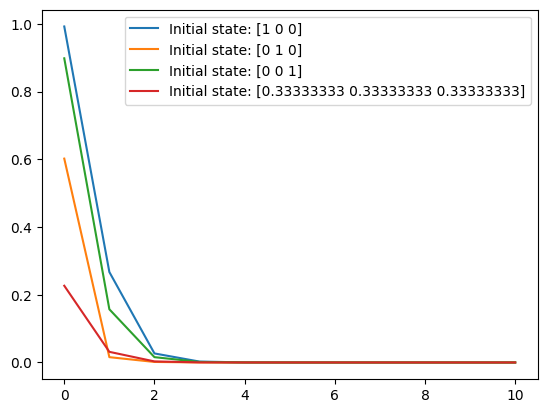

In [7]:
def markov_dist(p, init_dist, n):
    return init_dist.T @ np.linalg.matrix_power(p, n)

init_dists = [
    np.array([1,0,0]),
    np.array([0,1,0]),
    np.array([0,0,1]),
    np.array([1/3,1/3,1/3])
]
k = 10

for d in init_dists:
    errors = []
    for n in range(k+1):
        state = markov_dist(P, d, n)
        error = np.linalg.norm(state - v)
        errors.append(error)
    plt.plot(range(k+1), errors, label='Initial state: {}'.format(d))
plt.legend()
plt.show()

In [8]:
print(init_dists[0].T @ np.linalg.matrix_power(P, 1000))

[0.2        0.51111111 0.28888889]


### Absorbing State

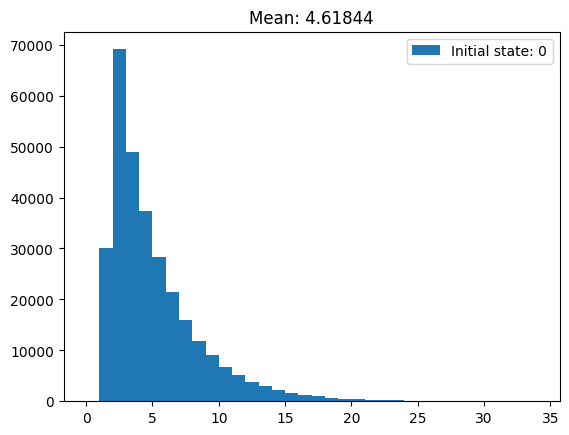

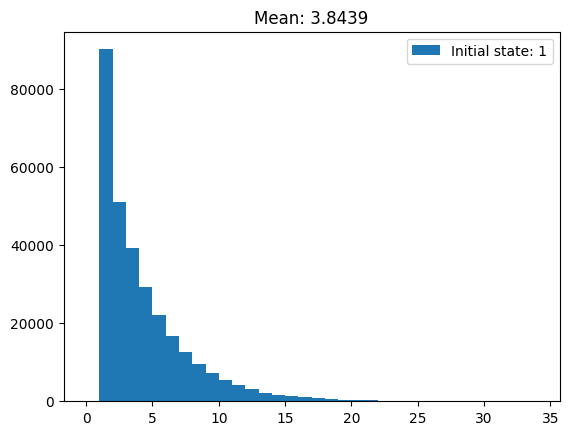

In [9]:
class MarkovChainAbsorbing(MarkovChain):
    def __init__(self, p, init, absorbing):
        super().__init__(p, init)
        self.absorbing = absorbing
        self.arrive = False
        self.arrive_gen = None
    def _update(self):
        if self.state != self.absorbing:
            super()._update()
        else:
            self.arrive = True
            self.arrive_gen = self.gen

def arrival_exp(p, init, absorbing, n):
    arrival_times = []
    for i in range(n):
        chain_absorb = MarkovChainAbsorbing(p, init, absorbing)
        chain_absorb.update(100)
        if chain_absorb.arrive:
            arrival_times.append(chain_absorb.arrive_gen)
        else:
            while not chain_absorb.arrive:
                chain_absorb.update(10)
                if chain_absorb.arrive:
                    arrival_times.append(chain_absorb.arrive_gen)
    return arrival_times


means = []
for init in range(2):
    arrival_times = arrival_exp(P, init, 2, 300000)
    means.append(np.mean(arrival_times))
    plt.hist(arrival_times, bins=np.arange(0,35,1), label='Initial state: {}'.format(init))
    plt.legend()
    plt.title('Mean: {}'.format(np.mean(arrival_times)))
    plt.show()

If $X_{i}=3$ is an absorbing state, then $T_{1}$ can be expressed as
$$
T_{1}=1+\mathbb{P}(X_{1}=1)\cdot T_{1}+\mathbb{P}(X_{1}=2)\cdot T_{2} + \mathbb{P}(X_{1}=3)\cdot T_{3}
$$
Because $X_{0}=1$ for $T_{1}$ and $T_{3}=0$, the equation above can be re-written as 
$$
T_{1}=1+0.2\cdot T_{1} + 0.7\cdot T_{2}
$$
We have a similar expression for $T_{2}$:
$$
T_{2}=1+0.2\cdot T_{1} + 0.5\cdot T_{2}
$$
Adding up the two equations we have
$$
0.6\cdot T_{1} = 2 + 0.2\cdot T_{2}
$$
Taking expectation on both sides we have
$$
2 + 0.2\cdot\mu_{2} - 0.6\cdot\mu_{1}
$$
Which we can evaluate using the calculated means, as shown below.

In [10]:
2 + 0.2 * means[1] - 0.6 * means[0]

-0.0022839999999995086

Taking in the values we have
$$
\mu_{1} = \frac{60}{13}=4.6154,\ \  \mu_{2} = \frac{50}{13}=3.8462
$$
Which corresponds to the numerical values from (a).